In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from matplotlib import pyplot

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

def show_rings_2(df):
  # little utility function to visualise galaxies on catalog

    fig, axes = plt.subplots(ncols=10,nrows = 5, figsize=(32, 16))
    for i in range(5):
        for j in range(10):
            galaxy = df.iloc[i*10+j]
            
            im = Image.open(galaxy['file_loc'])
            axes[i,j].imshow(im)
            
            axes[i,j].text(20, 70, 'Pred ring: {:.2f}, \n Pred non ring: {:.2f}'.format(galaxy['ring_pred'],galaxy['not_ring_pred']), color='g')
            axes[i,j].set_title(galaxy['iauname'])
            axes[i,j].axis('off')



In [57]:
from galaxy_datasets import gz2,gz_decals_5  # or gz_hubble, gz_candels, ...

gzd5_catalog_train, _ = gz_decals_5(
    root='data/gzd5',
    train=True,
    download=False
)

gzd5_catalog_test, _ = gz_decals_5(
    root='data/gzd5',
    train=False,
    download=False
)

gzd5_catalog = pd.concat([gzd5_catalog_train,gzd5_catalog_test])
gzd5_catalog = gzd5_catalog[['iauname','file_loc']].reset_index(drop=True).reset_index(names=['id_str'])

predictions_all = pd.read_csv('predictions_all_small-1-cosine.csv')

predictions_all.id_str = predictions_all.id_str.astype(int)
predictions_all = pd.merge(predictions_all, gzd5_catalog[['id_str', 'file_loc', 'iauname']])


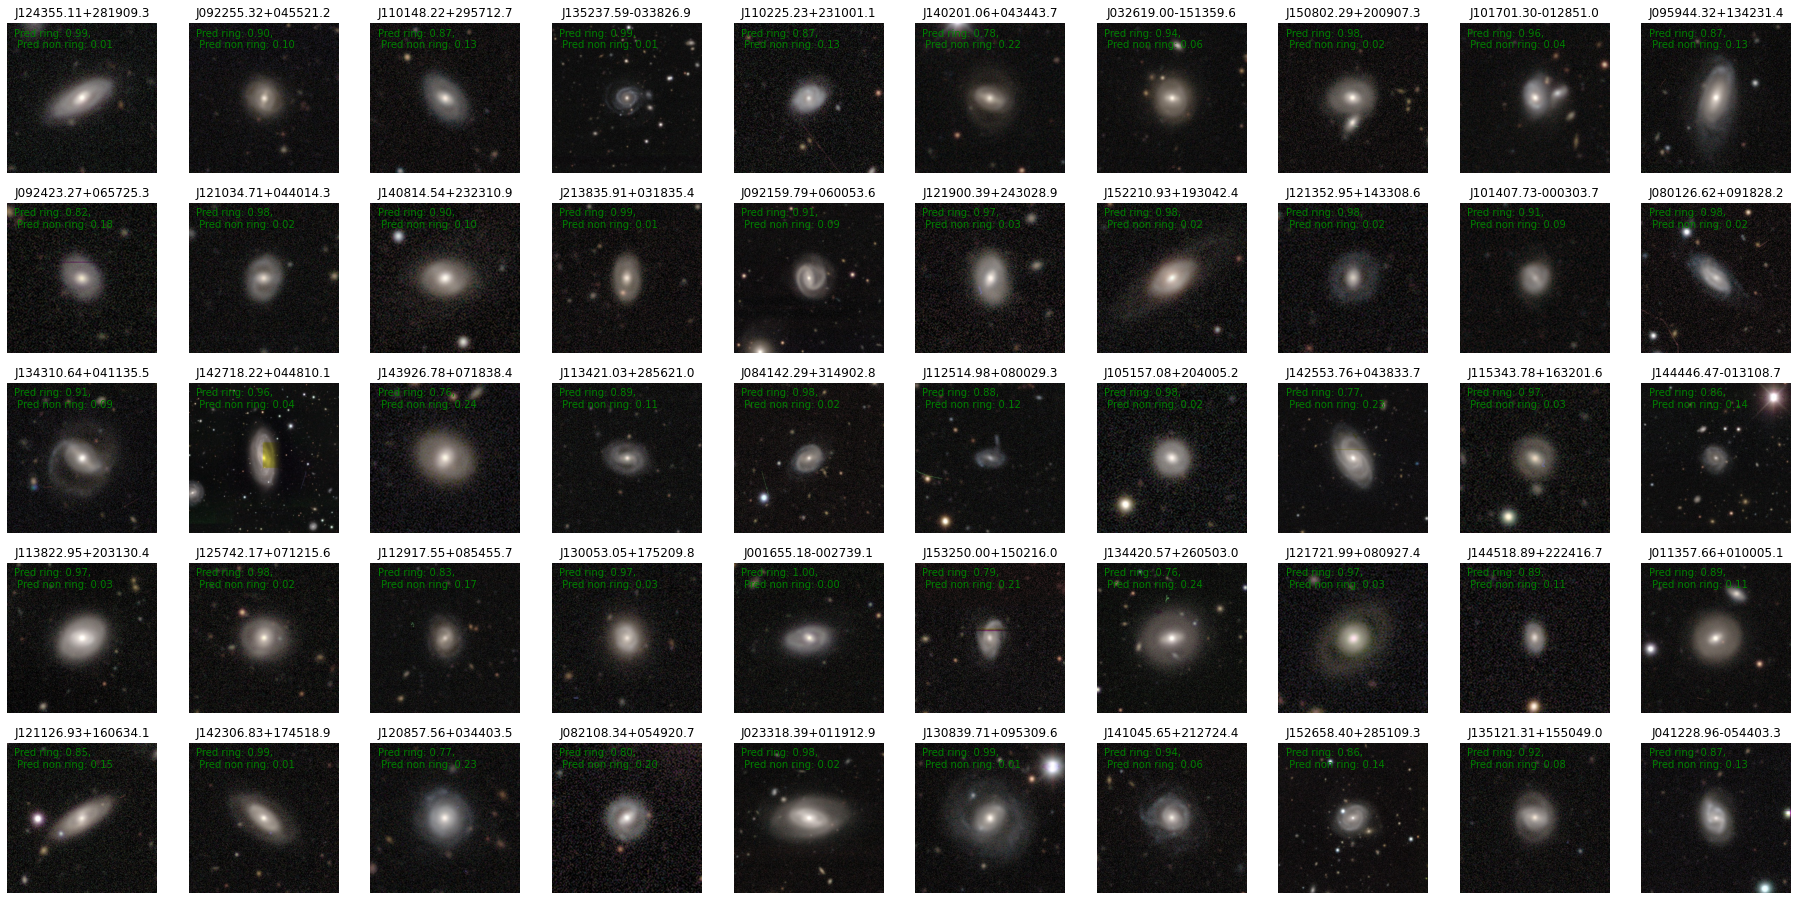

In [157]:
tmp = predictions_all[(predictions_all.ring_pred > 0.75) ]
tmp = tmp.sample(50)
show_rings_2(tmp)

In [83]:
test_data = pd.read_csv('predictions_test_small_1_cosine.csv').merge(pd.read_csv('train-test/gzd5_catalog_test.csv'), on =['id_str'])

In [136]:
# from sklearn.isotonic import IsotonicRegression

# calibrator = IsotonicRegression()

# calibrator.fit(test_data['ring_pred'], test_data['ring'])

# pred_calib = calibrator.predict(test_data['ring_pred'])
# pred_all_calib = calibrator.predict(predictions_all['ring_pred'])

Best Threshold=0.497471, G-Mean=0.963


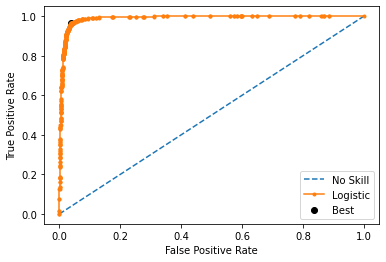

In [149]:

labels = test_data['ring']
preds = test_data['ring_pred']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(labels, preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.503026, G-Mean=0.963


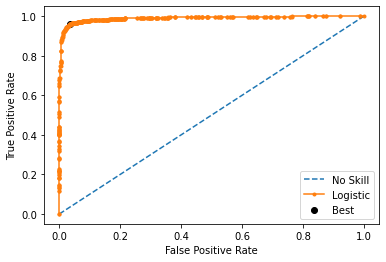

In [150]:

labels = 1 - test_data['ring']
preds = test_data['not_ring_pred']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(labels, preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

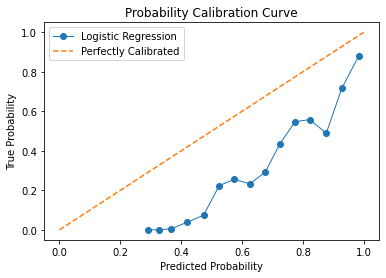

In [148]:
from sklearn.calibration import calibration_curve

true_pos, pred_pos = calibration_curve(test_data['ring'], test_data['ring_pred'], n_bins=20)
 
#Plot the Probabilities Calibrated curve
plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=1, 
         label='Logistic Regression')
 
#Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')
 
 
# Set the title and axis labels for the plot
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
 
# Add a legend to the plot
plt.legend(loc='best')
 
# Show the plot
plt.show()

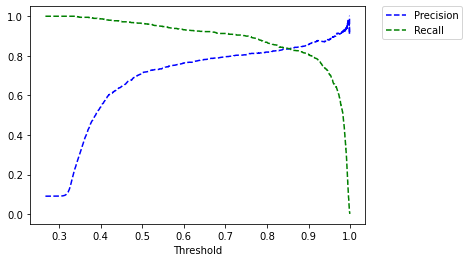

In [155]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve( test_data['ring'],test_data['ring_pred'])

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

Best Threshold=0.755625, F-Score=0.853


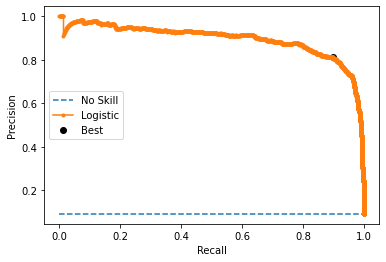

In [160]:
fscore = (2 * precisions * recalls) / (precisions + recalls)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

no_skill = len(test_data['ring'][test_data['ring']==1]) / len(test_data['ring'])
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recalls, precisions, marker='.', label='Logistic')
pyplot.scatter(recalls[ix], precisions[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [168]:
final_pred = predictions_all[(predictions_all.ring_pred > 0.755625)].sort_values('ring_pred',ascending = False)

<Axes: >

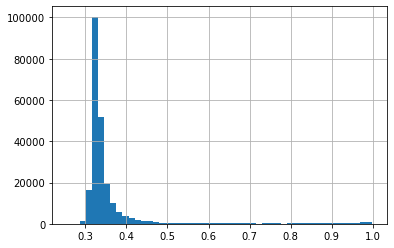

In [59]:
predictions_all.ring_pred.hist(bins =50)

<Axes: >

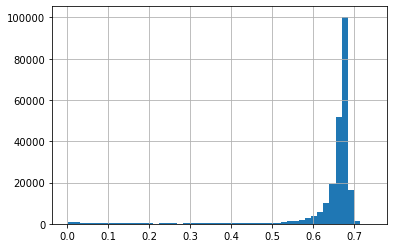

In [60]:
predictions_all.not_ring_pred.hist(bins =50)

In [166]:
predictions_all[(predictions_all.ring_pred > 0.755625)]

,id_str,not_ring_pred,ring_pred,file_loc,iauname
38,38,0.048005,0.951995,data/gzd5/images/J144/J144459.00+070004.1.jpg,J144459.00+070004.1
171,171,0.194348,0.805652,data/gzd5/images/J102/J102542.13+004546.8.jpg,J102542.13+004546.8
227,228,0.011613,0.988387,data/gzd5/images/J095/J095433.39+195102.4.jpg,J095433.39+195102.4
358,360,0.060253,0.939747,data/gzd5/images/J092/J092327.86+082825.9.jpg,J092327.86+082825.9
366,368,0.179451,0.820549,data/gzd5/images/J102/J102247.38+194730.1.jpg,J102247.38+194730.1
...,...,...,...,...,...
226399,227572,0.034195,0.965805,data/gzd5/images/J113/J113813.79-025323.0.jpg,J113813.79-025323.0
226563,227737,0.138022,0.861978,data/gzd5/images/J113/J113337.38+121536.7.jpg,J113337.38+121536.7
226654,227828,0.111211,0.888789,data/gzd5/images/J215/J215051.44+111653.9.jpg,J215051.44+111653.9
226828,228003,0.011555,0.988445,data/gzd5/images/J103/J103920.19+003814.3.jpg,J103920.19+003814.3


In [202]:
v5 = pd.read_parquet('gz_decals_volunteers_5.parquet')[['iauname','ra','dec','redshift','elpetro_absmag_r','sersic_nmgy_r','petro_th50','petro_th90','petro_theta']]
# v1_2 = pd.read_csv('gz_decals_volunteers_1_and_2.csv')[['iauname','ra','dec','redshift','elpetro_absmag_r','sersic_nmgy_r','petro_th50','petro_th90','petro_theta']]

catalog_cvs = v5#pd.concat([v5,v1_2])

final_pred_with_prop = final_pred.merge(catalog_cvs, on = ['iauname'], how = 'left')


In [191]:
final_pred_with_prop.to_csv('ring_galaxies.csv', index = False)